# Simple Classifiers and preprocessing of the data

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np


SEED = 42

## Importing of the data and spliting

next, we will import the dataset:

In [2]:
CSV_PATH = '../data/chartex_final.csv'

df = pd.read_csv(CSV_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_name         3932 non-null   object 
 1   track_pop          3932 non-null   int64  
 2   artist             3932 non-null   object 
 3   artist_pop         3932 non-null   int64  
 4   album              3932 non-null   object 
 5   danceability       3932 non-null   float64
 6   energy             3932 non-null   float64
 7   key                3932 non-null   float64
 8   loudness           3932 non-null   float64
 9   mode               3932 non-null   float64
 10  speechiness        3932 non-null   float64
 11  acousticness       3932 non-null   float64
 12  instrumentalness   3932 non-null   float64
 13  liveness           3932 non-null   float64
 14  valence            3932 non-null   float64
 15  tempo              3932 non-null   float64
 16  id                 3932 

Let's fill all missing data with the expectation:

In [3]:
df = df.drop(['track_name', 'artist', 'album', 'id', 'song_name', 'artist_name'], axis = 1, errors = 'ignore')
means = df.mean()
df.fillna(value=means, inplace=True)

next, we will split the target feature (number_of_videos) from the rest of the features and split to train and test sets. In addition, we will replace number_of_videos with a new binary feature that indicate if a track is popular on tiktok according to number_of_videos and threshold of our choice and it will be out target feature for **classification**:

In [4]:
from sklearn.model_selection import train_test_split

df = df.drop(['artist_pop', 'track_pop', 'number_of_videos_last_14days', 'total_likes_count', 'key',], axis = 1, errors = 'ignore')
columns = df.columns

X, y = df.drop(['number_of_videos'], axis=1, errors = 'ignore').values,  df['number_of_videos'].values

Let's look at the distribution of the target feature and also its mean and few quantiles:

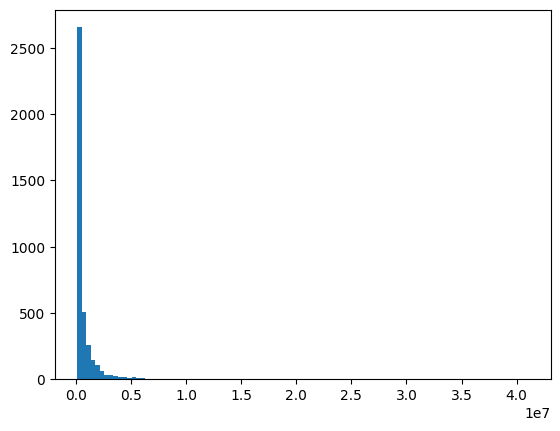

In [5]:
import matplotlib.pyplot as plt

plt.hist(y, bins=100)
plt.show()

In [6]:
p = [0.3,0.4,0.5,0.6,0.7]
q = np.quantile(y, p)

print(f'Mean of target feature: {np.mean(y)} .')

for prob, quant in zip(p,q):
    print(f'The quantile of {prob} is {quant} .')

y_min = np.min(y)
y_max = np.max(y)

print(f'The max value is {y_max} and the min value is {y_min} .')
print(f'The range of the target feature is {y_max - y_min} .')

Mean of target feature: 794857.4763479145 .
The quantile of 0.3 is 230794.4 .
The quantile of 0.4 is 277940.0 .
The quantile of 0.5 is 345250.0 .
The quantile of 0.6 is 443660.0 .
The quantile of 0.7 is 607300.0 .
The max value is 41049300 and the min value is 147400 .
The range of the target feature is 40901900 .


We can notice that the mean of y is higher than the quantile of 0.7 (which is make sense considering the distribution of the target, as we can see in the plot above). We wish to have as balanced as possible data and therefore the mean is not the right threshold. On the other hand, the median is very low value considering the min and max of the target (it is very close to the min and very far from the max). Therefore, we will choose 500,000 as the threshold (still balanced).

In [7]:
y = (y > 5e5).astype('int32')

To conclude, for now, the features we will work on are:

In [8]:
print(f'Target: number_of_videos')
i = 0
for column in columns:
    if not column == 'number_of_videos':
        print(f'#{i} : {column}')
        i+=1

Target: number_of_videos
#0 : danceability
#1 : energy
#2 : loudness
#3 : mode
#4 : speechiness
#5 : acousticness
#6 : instrumentalness
#7 : liveness
#8 : valence
#9 : tempo
#10 : duration_ms
#11 : time_signature
#12 : chroma_stft
#13 : rmse
#14 : spec_cent
#15 : spec_bw
#16 : rolloff
#17 : zcr
#18 : mfcc


And now we will split the data between training and test sets:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.25)

Let's investigate a bit the train and test sets:

In [10]:
print("Train:")
print("#samples in train:", y_train.shape[0])
print("#popular samples in train:", y_train.sum().item()/y_train.shape[0])

print("\nTest:")
print("#samples in test:", y_test.shape[0])
print("#popular samples in test:", y_test.sum().item()/y_test.shape[0])

Train:
#samples in train: 2949
#popular samples in train: 0.35232282129535436

Test:
#samples in test: 983
#popular samples in test: 0.38351983723296035


## Simple classifiers:

In [11]:
from sklearn.model_selection import cross_validate

def print_accuracy(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_train)
    print("train accuracy =",(y_train == y_pred).mean())

    y_pred = model.predict(X_test)
    print("test accuracy =",(y_test == y_pred).mean())

splitted_data = (X_train, X_test, y_train, y_test)

### Logistic regression:

Now we are ready to train the models.

We will start with Logistic regression with l2 regularization:

In [54]:
from sklearn import linear_model

logit_lin_l2_model = linear_model.LogisticRegression(C = 5)
logit_lin_l2_model.fit(X_train,y_train)

LogisticRegression(C=5)

In [55]:
print_accuracy(logit_lin_l2_model, *splitted_data)

train accuracy = 0.6480162767039674
test accuracy = 0.6164801627670397


We can see that the model is just better than random classifier.

Considering that we used the model on the raw data it is not suprising that the model did bad job in predicting the popularity.

Let's try decision trees!

### Decision Trees:

Let's put regularization by forcing all leaves in the tree to have at least 10 samples from the training set:

In [56]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 10)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=10)

In [58]:
print_accuracy(tree_model, *splitted_data)

train accuracy = 0.9284503221430993
test accuracy = 0.5188199389623601


Has we can see from the result, the model suffers from overfitting. So, let's do cross validation on min_samples_split:

In [59]:
from sklearn import tree

list_of_mins = [10,50,100,300,500,1000]
accuracy_per_value = []

for min_leaf in list_of_mins:
    tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_leaf)
    cv_result = cross_validate(tree_model, X_train, y_train, cv=3, scoring= ('accuracy'))
    accuracy_per_value.append(cv_result['test_score'].mean())

optim_min = list_of_mins[np.argmax(accuracy_per_value)]
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = optim_min)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=1000)

And then, the accuracies of the model with the optimal min_samples_split is:

In [60]:
print_accuracy(tree_model, *splitted_data)

train accuracy = 0.6697185486605629
test accuracy = 0.6052899287894201


Still not a good result. We need to remember that we are still working on the row data and didn't do any feature mapping

### AdaBoost classifier:

Let's play with AdaBoost a bit:

In [61]:
from sklearn.ensemble import AdaBoostClassifier

#the base model is stump - decision tree with maximal depth of 1.
adaboost_model = AdaBoostClassifier(n_estimators=50, learning_rate=20)
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=20)

In [62]:
print_accuracy(adaboost_model, *splitted_data)

train accuracy = 0.6490335707019329
test accuracy = 0.6174974567650051


Let's see if Cross validation can help it:

In [63]:
estimators = [10, 25, 50]
lr = [0.01, 0.1, 1]
accuracy_per_value = []

for n_estimator in estimators:
    for rate in lr:
        adaboost_model = AdaBoostClassifier(n_estimators=n_estimator, learning_rate= rate)
        cv_result = cross_validate(adaboost_model, X_train, y_train, cv=3, scoring= ('accuracy'))
        accuracy_per_value.append(cv_result['test_score'].mean())

optim_idx = np.argmax(accuracy_per_value)
adaboost_model = AdaBoostClassifier(n_estimators= estimators[optim_idx//len(lr)], learning_rate= lr[optim_idx%len(lr)])
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=10)

In [64]:
print_accuracy(adaboost_model, *splitted_data)

train accuracy = 0.6476771787046457
test accuracy = 0.6164801627670397


### MLP model:

Let's check how many features we have:

In [12]:
input_dim = X_train.shape[1]
output_dim = 2
train_samples = X_train.shape[0]

print("input dim:", input_dim)
print("number of train samples:", train_samples)
print("number of test samples:", X_test.shape[0])

input dim: 19
number of train samples: 2949
number of test samples: 983


In [13]:
import torch
import torch.nn as nn

torch.manual_seed(SEED)

X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.long)


In [14]:
batch_size = 64

num_epochs = 100
num_batches = train_samples//batch_size

#### Overfitting on small subset test:

We will start by checking if it is possible to overfit the MLP on small subset of the training set: (in order to see if the implementation of trainer and dataIterator module are good):

In [15]:
overfit_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 16),
    nn.LeakyReLU(),
    nn.Linear(16, output_dim),
    nn.Softmax(dim=1)
)

print(overfit_model)

Sequential(
  (0): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=19, out_features=16, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=16, out_features=2, bias=True)
  (4): Softmax(dim=1)
)


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=1e-2)

In [17]:
from src.trainer import trainer

overfit_trainer = trainer(overfit_model,optimizer,loss_fn,num_epochs,batch_size, None,True)

loss_list, accuracy_list = overfit_trainer.fit(X_train=X_train[:50],y_train=y_train[:50])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 584.56it/s]

Epoch #99: Loss=0.33441078662872314, accuracy=0.98


Success! Now we can move on to a real training.

#### Simple MLP:

In [26]:
mlp_model = nn.Sequential(
    nn.BatchNorm1d(input_dim),
    nn.Linear(input_dim, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 32),
    nn.LeakyReLU(),
    nn.Linear(32, output_dim),
    nn.Softmax(dim=1)
)

print(mlp_model)

Sequential(
  (0): BatchNorm1d(19, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=19, out_features=64, bias=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=32, out_features=2, bias=True)
  (6): Softmax(dim=1)
)


In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

In [28]:
from src.trainer import trainer

mlp_trainer = trainer(mlp_model,optimizer,loss_fn,num_epochs,batch_size,scheduler,True)

loss_list, accuracy_list = mlp_trainer.fit(X_train=X_train,y_train=y_train)

100%|██████████| 100/100 [00:05<00:00, 17.87it/s]

Epoch #99: Loss=28.61137256026268, accuracy=0.6873516446252967


Text(0, 0.5, 'accuracy')

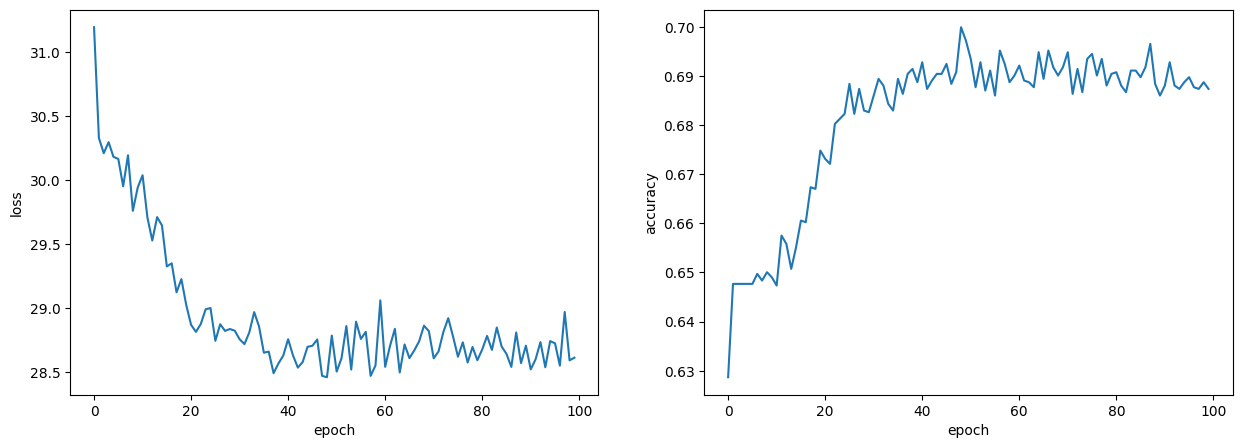

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(range(num_epochs), loss_list)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(range(num_epochs), accuracy_list)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')


In [30]:
y_pred = mlp_model(X_test)
test_accuracy = (torch.argmax(y_pred,dim=1) == y_test).sum().item() / X_test.shape[0]
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.6032553407934893


We can notice a bit of overfitting because while the train accuracy is above above 74%, the test accuracy is just above 60%.

In addition, it seems that the learning rate is not correct because the decrease in the loss is very small, preventing the model to learn well.

We will next do cross validation on few hyperparameters in order to get the better model.

#### Cross validation for MLP:

In [55]:
import torch
import torch.nn as nn
from src.cross_val import setConfigure, crossValidate

In [81]:
from sklearn.model_selection import KFold
from src.trainer import trainer

num_epochs = 100

kf = KFold(2,shuffle=True, random_state=SEED)

configures = setConfigure({'lr':[1e-3],'weight_decay': [1e-3,5e-4,1e-4]})

results = []
for config in configures:
    mlp_model = nn.Sequential(
        nn.BatchNorm1d(input_dim),
        nn.Linear(input_dim, 32),
        nn.LeakyReLU(),
        nn.Linear(32, output_dim),
        nn.Softmax(dim=1)
    )
    print(f'The configuration is {config}:')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)

    mlp_trainer = trainer(mlp_model,optimizer,loss_fn,num_epochs,batch_size,None,True)
    results.append(crossValidate(mlp_trainer, X_train, y_train, kf))

The configuration is {'lr': 0.001, 'weight_decay': 0.001}:


100%|██████████| 100/100 [00:02<00:00, 38.69it/s]


Epoch #99: Loss=15.161360561847687, accuracy=0.6865671641791045


100%|██████████| 100/100 [00:02<00:00, 40.95it/s]


Epoch #99: Loss=14.638643383979797, accuracy=0.6894915254237288
The configuration is {'lr': 0.001, 'weight_decay': 0.0005}:


100%|██████████| 100/100 [00:02<00:00, 40.35it/s]


Epoch #99: Loss=14.996379792690277, accuracy=0.6926729986431479


100%|██████████| 100/100 [00:02<00:00, 41.02it/s]


Epoch #99: Loss=14.357777833938599, accuracy=0.6996610169491525
The configuration is {'lr': 0.001, 'weight_decay': 0.0001}:


100%|██████████| 100/100 [00:02<00:00, 39.76it/s]


Epoch #99: Loss=15.09365177154541, accuracy=0.6987788331071914


100%|██████████| 100/100 [00:02<00:00, 38.10it/s]

Epoch #99: Loss=14.660684138536453, accuracy=0.7152542372881356


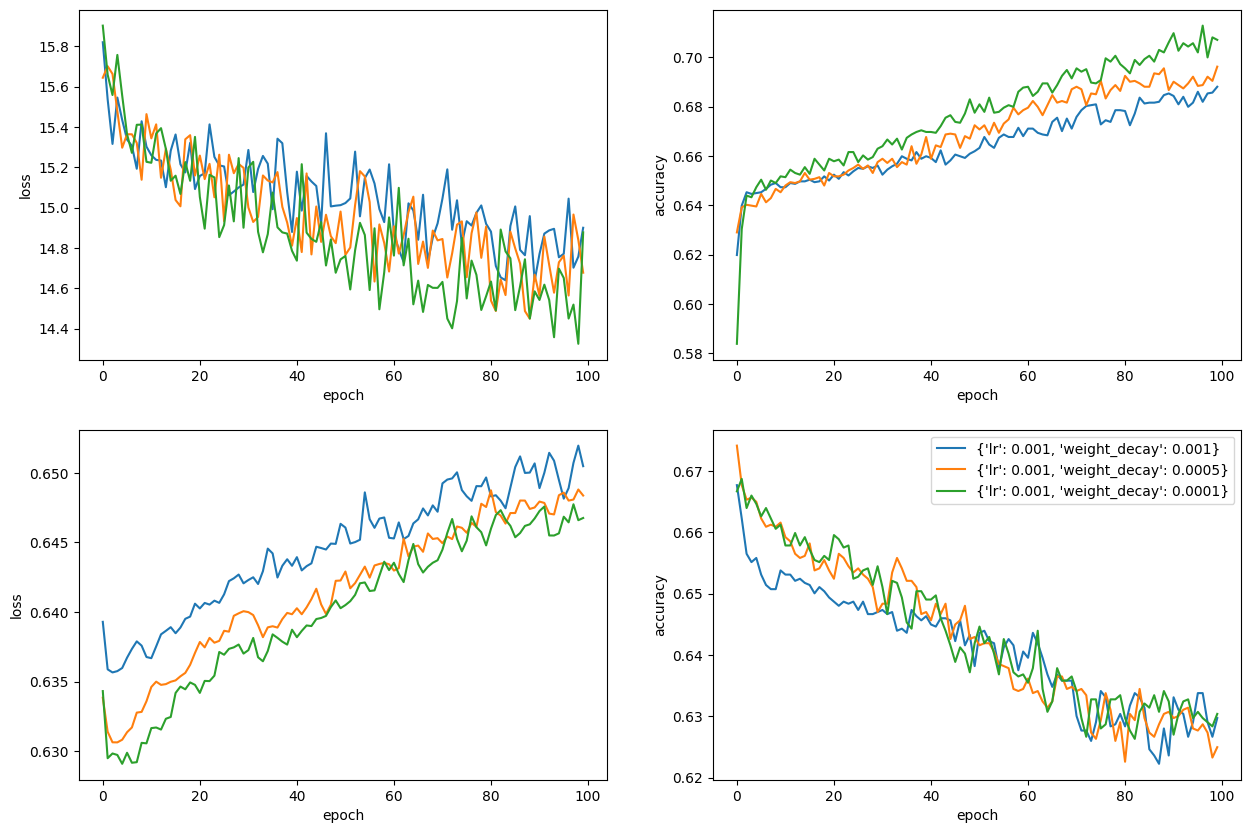

In [82]:
from src.utils.plot_utils import plotCV

plotCV(results, configures)

### Others:

In [ ]:
#Save the entire model:
#torch.save(model, "my_model.pickle")
#model = torch.load("my_model.pickle")

#Save only the weights: (recommended)
#torch.save(model.state_dict(), "my_model.pickle")
#model = nn.Sequential(...)
#model.load_state_dict(torch.load("my_model.pickle"))